In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet

In [8]:
# 1. Data Loading and Preparation

# Load the aggregated monthly data (simulated from sales_forecast_data.csv)
try:
    # In a real scenario, replace this with a function to load data directly from your PostgreSQL query
    df = pd.read_csv('sales_forecast_data.csv')
except FileNotFoundError:
    print("ERROR: sales_forecast_data.csv. Please ensure the file is present")
    exit()

# Prophet requires the columns to be named specifically: 'ds' for the date and 'y' for the metric.
df['ds'] = pd.to_datetime(df['ds'])
df['ds'] = df['ds'].dt.tz_localize(None)

df

,ds,y
0,2022-01-01,50525.0
1,2022-02-01,41579.5
2,2022-03-01,38566.0
3,2022-04-01,38650.0
4,2022-05-01,38752.5
5,2022-06-01,40846.0
6,2022-07-01,41098.5
7,2022-08-01,38178.0
8,2022-09-01,44287.0
9,2022-10-01,35580.5


In [10]:
# 2. Model Initializing and Training

# Initialize the Prophet model.
# We explicitly enable 'yearly_seasonality' because retail sales have strong annual cycles (e.g., holidays).
m = Prophet(
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    seasonality_mode='multiplicative' # Use multiplicative mode for retail; seasonality spikes tend to grow with the trend
)

# Fit the model to the historical data
m.fit(df)

20:22:50 - cmdstanpy - INFO - Chain [1] start processing
20:22:50 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# 3. Future Dataframe creation

# Create a DataFrame for 12 months into the future.
# 'freq="MS"' means Month Start frequency.

future = m.make_future_dataframe(periods=12, freq='MS')

In [14]:
# 4. Prediction

# Make the forecast
forecast = m.predict(future)

Sales Forecast Summary (Next 12 Months)
        ds         yhat   yhat_lower   yhat_upper
2025-02-01 38436.959495 34560.809383 42499.160181
2025-03-01 37811.519079 34168.836286 41887.535251
2025-04-01 39191.688670 35273.849448 43262.994598
2025-05-01 38705.442608 34713.345437 42676.637990
2025-06-01 39646.278457 35749.027884 43357.702567
2025-07-01 38613.438659 34665.751113 42466.538359
2025-08-01 37953.900447 34130.214860 41971.853378
2025-09-01 39042.597685 35111.994824 42730.674900
2025-10-01 37243.243980 33275.910874 41306.024766
2025-11-01 38414.866673 34045.142206 42227.052491
2025-12-01 40931.169730 36821.834789 44771.640525
2026-01-01 36828.966451 33143.840495 40740.597669


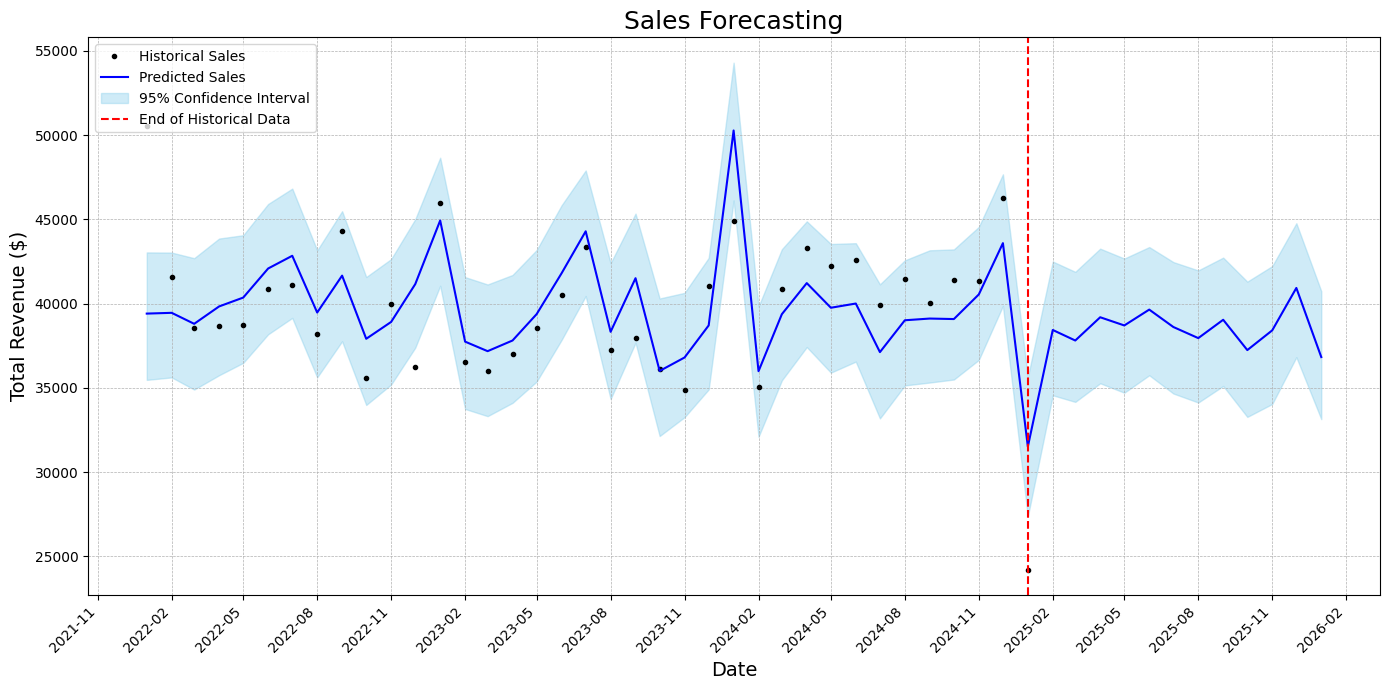

In [25]:
# 5. Visualization

print("Sales Forecast Summary (Next 12 Months)")
print(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(12).to_string(index=False))

# Plot the forecast
fig, ax = plt.subplots(figsize=(14,7))

# Plot the actual historical data
ax.plot(df['ds'], df['y'], 'k.', label ='Historical Sales')

# Plot the predicted line (yhat)
ax.plot(forecast['ds'], forecast['yhat'], color = 'blue', linestyle ='-', label = 'Predicted Sales')

# Plot the confidence interval (yhat_lower, yhat_upper)
ax.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color = 'skyblue',
    alpha = 0.4,
    label = '95% Confidence Interval'
)

# Highlight the forecast period
historical_end_date = df['ds'].max()
ax.axvline(x=historical_end_date, color='red', linestyle='--', label='End of Historical Data')

# Formatting the plot
ax.set_title('Sales Forecasting', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Total Revenue ($)', fontsize=14)
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve X-axis date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

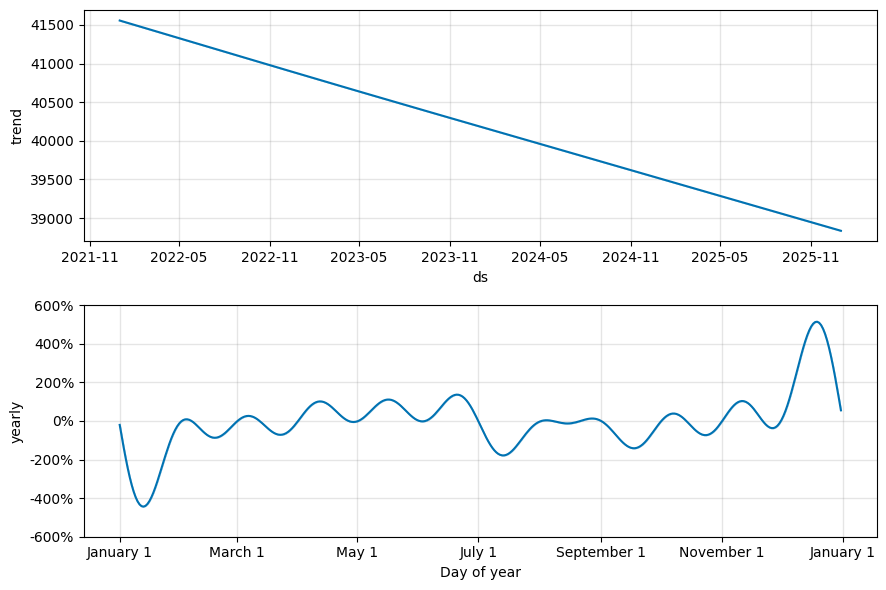

In [26]:
# 6. Plotting Trend and Seasonality Components

# This is a key part of Prophet analysis, showing the model's breakdown of the time series
m.plot_components(forecast)
plt.show